# Latent Variable Models : applications and examples

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Reminder & warm-up

An EM algorithm is an iterative optimization of the following variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT$.

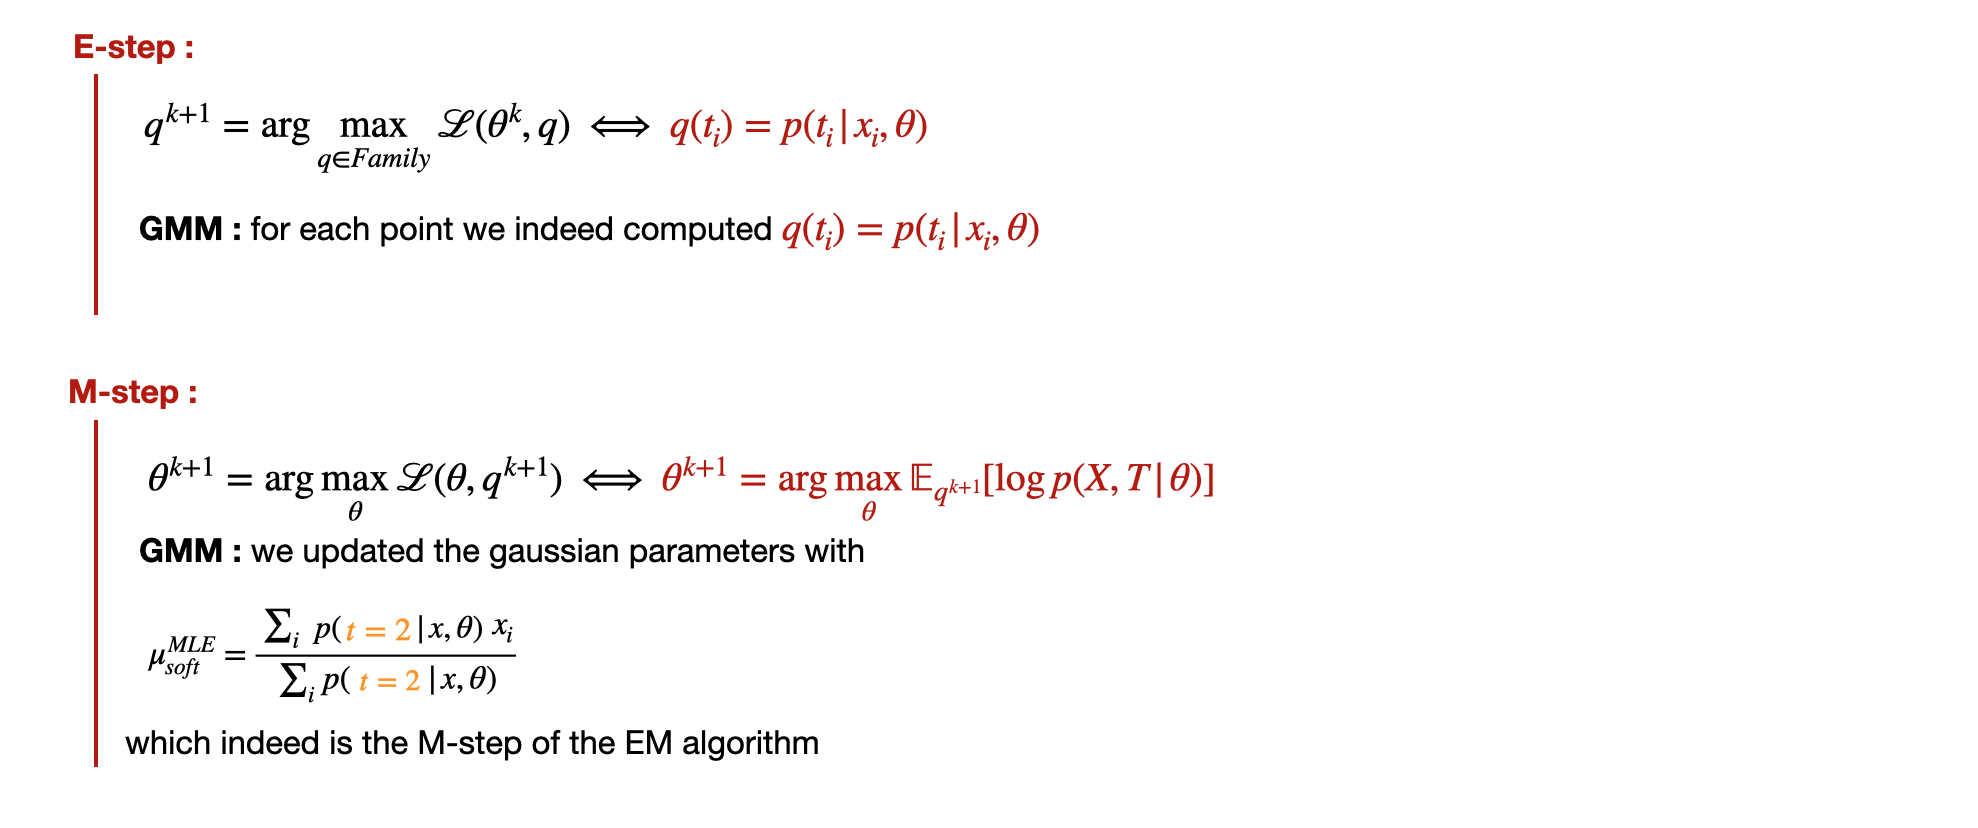

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data["data"]
y = data["target"]

**Question 1 :** Give the shape of X and y.

In [3]:
# Get the shapes of X and y
shape_X = X.shape
shape_y = y.shape

shape_X,shape_y

((569, 30), (569,))

**Question 2 :** Plot the first two dimension of X and color the instances according to its class y

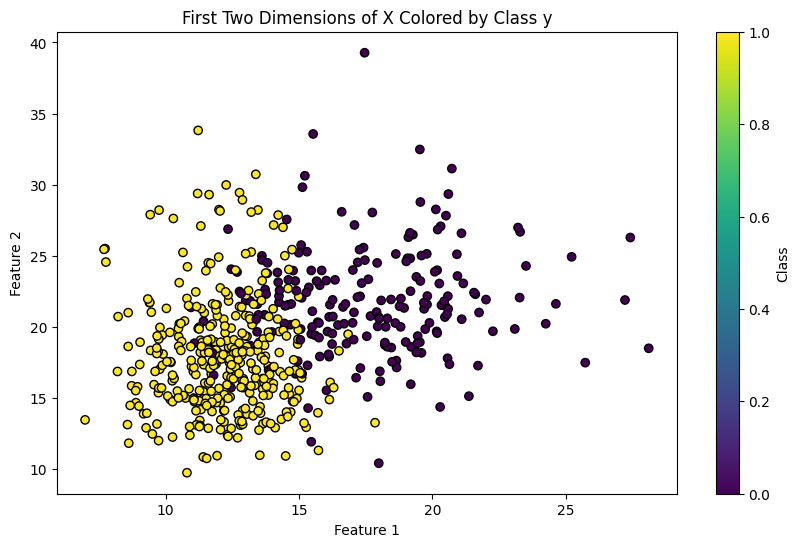

In [4]:
import matplotlib.pyplot as plt

# Extract the first two dimensions of X
X_first_two = X[:, :2]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_first_two[:, 0], X_first_two[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First Two Dimensions of X Colored by Class y')
plt.colorbar(label='Class')
plt.show()


For the sake of the following section, let us discard completely the class y.

## 1. Clustering : a probabilistic point of view with k-means

We recall that k-means is a clustering algorithm which has the following pseudo-algorotihm :

**Input :** number of clusters $K$, dataset $X$

**Output :** the clusters

1. Randomly initialize the parameters $\theta = \{centroid_1, \dots, centroid_K\}$

2. Repeat until convergence :
    - For each instance $x$, compute the closest centroid :
    $$
    k_i = \arg\min_{k} \lVert x_i - centroid_k \lVert^2
    $$
    
    - Update the centroids :
    $$
    centroid_k = \frac{\sum_{i:k_i=k} x_i}{|{i:k_i=k}|}
    $$

**Question 3 :** Define the function `kmeans_naive` and test it out on $X$ with $K=3$. Plot the first two dimensions of $X$ and color the instances according to its cluster

In [5]:
def kmeans_naive(X, K, max_iters=100):
    # Randomly initialize centroids
    np.random.seed(42)
    initial_indices = np.random.choice(X.shape[0], K, replace=False)
    centroids = X[initial_indices]
    
    for _ in range(max_iters):
        # Assignment step: assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Update step: compute new centroids
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Run kmeans_naive on X with K=3
labels, centroids = kmeans_naive(X, K=3)

# Extract the first two dimensions of X
X_first_two = X[:, :2]


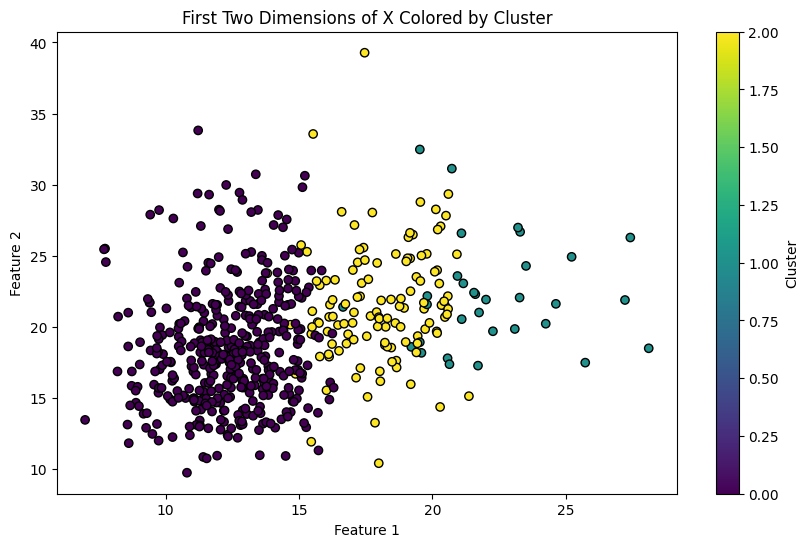

In [7]:

plt.figure(figsize=(10, 6))
plt.scatter(X_first_two[:, 0], X_first_two[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First Two Dimensions of X Colored by Cluster')
plt.colorbar(label='Cluster')
plt.show()

**Question 4 :** Define the function `GMM_hard` (p.24) which fit a Gaussian Mixture Model (with hard clustering). We assume two things here 
- $\Sigma = I_d$ is **known** and is identical ;
- $\pi_k$ is known and is uniform.

In [8]:
import numpy as np

def GMM_hard(X, K, max_iters=100):
    np.random.seed(42)
    n, d = X.shape
    
    # Initialize means randomly from the data points
    initial_indices = np.random.choice(n, K, replace=False)
    means = X[initial_indices]
    
    for _ in range(max_iters):
        # E-step: Assign each data point to the nearest mean
        distances = np.linalg.norm(X[:, np.newaxis] - means, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # M-step: Update means
        new_means = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        
        # Check for convergence
        if np.all(means == new_means):
            break
        
        means = new_means
    
    return labels, means

# Test the GMM_hard function on X with K=3
labels, means = GMM_hard(X, K=3)


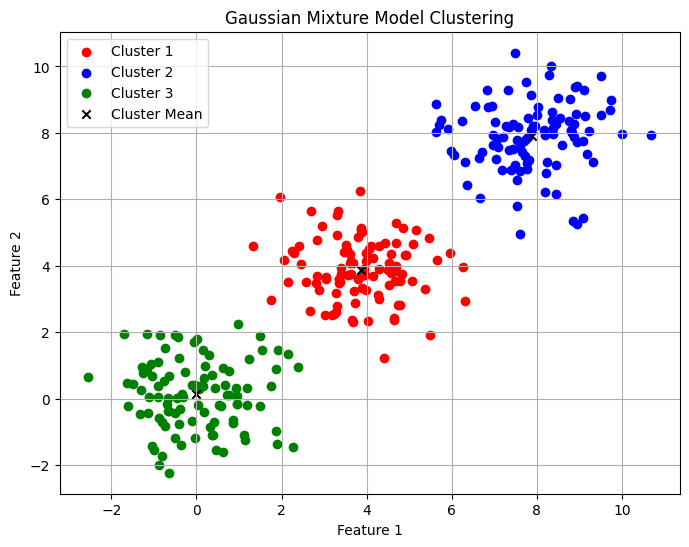

In [9]:


# Generate sample data for demonstration
np.random.seed(0)
X = np.concatenate([np.random.normal(loc=0, scale=1, size=(100, 2)),
                    np.random.normal(loc=4, scale=1, size=(100, 2)),
                    np.random.normal(loc=8, scale=1, size=(100, 2))])

# Function to plot data points and cluster means
def plot_clusters(X, labels, means):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'purple', 'orange']  

    # Plot data points
    for k in range(len(np.unique(labels))):
        plt.scatter(X[labels == k][:, 0], X[labels == k][:, 1], color=colors[k], label=f'Cluster {k+1}')

    # Plot cluster means
    plt.scatter(means[:, 0], means[:, 1], marker='x', color='black', label='Cluster Mean')

    plt.title('Gaussian Mixture Model Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the GMM_hard function on X with K=3
labels, means = GMM_hard(X, K=3)

# Plot the clusters
plot_clusters(X, labels, means)



**Question 5 :** What do we see ?

- Data Points: The small blue, green, and red dots represent the data points used for clustering. There appear to be three distinct clusters, which aligns with the three centroids used in the GMM clustering algorithm (K=3).

- Clusters: The data points are colored based on the cluster they were assigned to by the GMM algorithm. Ideally, the points within a cluster should be close together, indicating they share similar features. In this image, the clustering appears to have successfully separated the data into three well-defined groups.

- Cluster Means: The large black 'x' symbols represent the means (centroids) of each cluster. The GMM algorithm identifies these centroids as the centers of gravity for each cluster.

Overall, the visualization suggests that the GMM clustering has effectively separated the data points into three meaningful clusters.

**Question 5 :** Redefine `GMM_hard` and let us take assume that $\Sigma_k$ and $\pi_k$ are no longer known. Plot the results

In [13]:
def GMM_hard(X, K, max_iters=100, tol=1e-4):
    np.random.seed(42)
    n, d = X.shape
    
    # Initialize means randomly from the data points
    initial_indices = np.random.choice(n, K, replace=False)
    means = X[initial_indices]
    
    # Initialize covariances and mixing coefficients
    covariances = [np.cov(X.T)] * K  # Start with the same covariance matrix for each component
    mix_coefficients = np.ones(K) / K  # Uniform mixing coefficients
    
    log_likelihoods = []
    
    for iter in range(max_iters):
        # E-step: Compute responsibilities
        responsibilities = np.zeros((n, K))
        for k in range(K):
            mvn = multivariate_normal(mean=means[k], cov=covariances[k])
            responsibilities[:, k] = mix_coefficients[k] * mvn.pdf(X)
        
        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        # M-step: Update parameters
        Nk = responsibilities.sum(axis=0)
        means_new = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        
        covariances_new = []
        for k in range(K):
            cov_k = (responsibilities[:, k, np.newaxis] * (X - means_new[k])).T @ (X - means_new[k]) / Nk[k]
            covariances_new.append(cov_k)
        
        mix_coefficients_new = Nk / n
        
        # Calculate log likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        log_likelihoods.append(log_likelihood)
        
        # Check convergence
        if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
        
        # Update parameters
        means = means_new
        covariances = covariances_new
        mix_coefficients = mix_coefficients_new
    
    # Assign labels based on maximum responsibility
    labels = np.argmax(responsibilities, axis=1)
    
    return labels, means, covariances, mix_coefficients, log_likelihoods

# Function to plot data points and ellipses for GMM components
def plot_gmm_clusters(X, labels, means, covariances):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'purple', 'orange']  # Define colors for up to 5 clusters
    
    # Plot data points
    for k in range(len(np.unique(labels))):
        plt.scatter(X[labels == k][:, 0], X[labels == k][:, 1], color=colors[k], label=f'Cluster {k+1}')

    # Plot ellipses for GMM components
    for k in range(len(means)):
        plot_cov_ellipse(covariances[k], means[k], nstd=2, color=colors[k], alpha=0.2)

    plt.title('Gaussian Mixture Model Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()



**[OPTIONAL] Question 6 :** Define `GMM_soft` which fit a GMM with soft clustering. Plot the results

c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


TypeError: __init__() takes 4 positional arguments but 5 were given

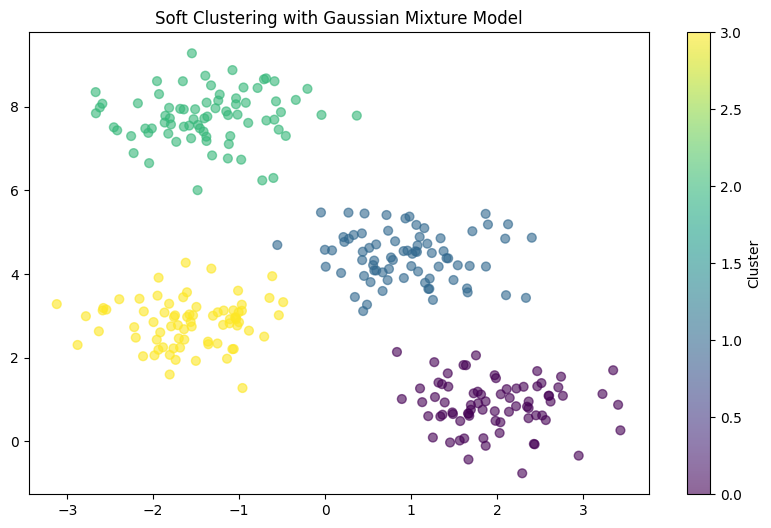

In [12]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

def plot_gmm_soft(X, gmm):
    # Fit the GMM
    gmm.fit(X)
    # Predict clusters
    labels = gmm.predict(X)
    # Get probabilities of each sample belonging to each cluster
    probs = gmm.predict_proba(X)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Cluster')
    plt.title('Soft Clustering with Gaussian Mixture Model')
    
    # Plotting the ellipses representing the covariance of each mixture component
    from matplotlib.patches import Ellipse
    import matplotlib.colors as mcolors
    
    colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, gmm.n_components)]
    
    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi 
        
        ell = Ellipse(mean, v[0], v[1], 180. + angle, color=colors[i])
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def GMM_soft(X, n_components=3):
    # Initialize Gaussian Mixture Model with soft clustering
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    return gmm

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Initialize and plot GMM with soft clustering
gmm = GMM_soft(X, n_components=4)
plot_gmm_soft(X, gmm)

## 2. Dimensionality reduction : a probabilistic point of view with PCA

PPCA is a dimensionality reduction technique that is often used when we have some missing values in the dataset. We assume that each latent variable is normally distributed :
$$
t_i \sim \mathcal{N}(0, I_K)
$$

The instance $x$ associated is generated by the following projection :
$$
x_i | t_i \sim \mathcal{N}(W\cdot t_i + b, \Sigma)
$$

**Question 7 :** The PPCA is a general form of PCA. Indeed, we can observe it in marginalizing the latent variable. Find out the distribution of each instance $x | \theta$ (you can use the wikipedia table for the normal conjugacy).

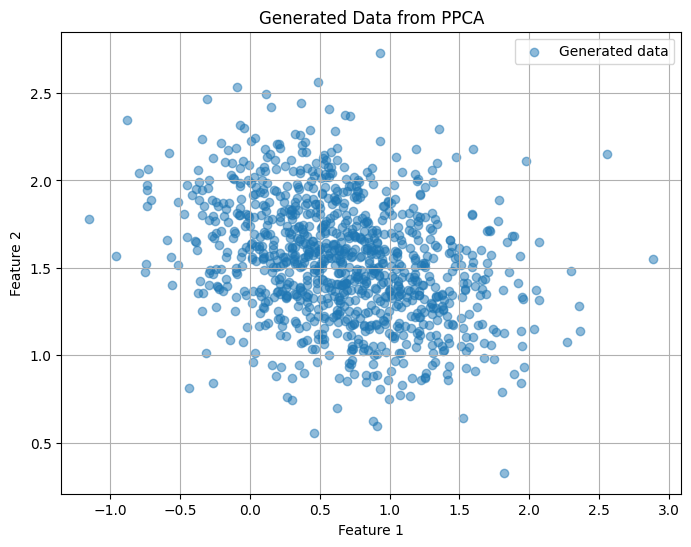

Empirical Mean:
[0.66400946 1.53664135]
Empirical Covariance:
[[ 0.33040804 -0.06351567]
 [-0.06351567  0.12168187]]
Theoretical Mean:
[0.64768854 1.52302986]
Theoretical Covariance:
[[ 0.34672495 -0.06867784]
 [-0.06867784  0.11911702]]


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
p = 2  # Dimensionality of observed data
d = 1  # Dimensionality of latent variable
n_samples = 1000  # Number of data samples

# Generate random parameters for PPCA
np.random.seed(42)
W = np.random.randn(p, d)
mu = np.random.randn(p)
sigma2 = 0.1

# Generate latent variable z
z = np.random.randn(n_samples, d)

# Generate observed data x
epsilon = np.random.randn(n_samples, p) * np.sqrt(sigma2)
x = z @ W.T + mu + epsilon

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='Generated data')
plt.title('Generated Data from PPCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Compute the empirical mean and covariance
empirical_mean = np.mean(x, axis=0)
empirical_cov = np.cov(x, rowvar=False)

print(f"Empirical Mean:\n{empirical_mean}")
print(f"Empirical Covariance:\n{empirical_cov}")

# Compute the theoretical mean and covariance
theoretical_mean = mu
theoretical_cov = W @ W.T + sigma2 * np.eye(p)

print(f"Theoretical Mean:\n{theoretical_mean}")
print(f"Theoretical Covariance:\n{theoretical_cov}")


**Question 8 :** Compute the E-step of the PPCA

In [15]:
# Define parameters
p = 2  # Dimensionality of observed data
d = 1  # Dimensionality of latent variable
n_samples = 1000  # Number of data samples

# Randomly generate the parameters for PPCA
np.random.seed(42)
W = np.random.randn(p, d)
mu = np.random.randn(p)
sigma2 = 0.1

# Generate synthetic observed data x
z = np.random.randn(n_samples, d)
epsilon = np.random.randn(n_samples, p) * np.sqrt(sigma2)
x = z @ W.T + mu + epsilon

# Compute M
M = W.T @ W + sigma2 * np.eye(d)

# Initialize arrays to store E-step results
Ez = np.zeros((n_samples, d))
Covz = sigma2 * np.linalg.inv(M)

# Compute E[z | x] and Cov(z | x) for each data point
for i in range(n_samples):
    xi = x[i]
    Ez[i] = np.linalg.inv(M) @ W.T @ (xi - mu)

# Print the first few values of Ez and Covz
print(f"Posterior mean (E[z | x]) for the first few data points:\n{Ez[:5]}")
print(f"Posterior covariance (Cov(z | x)):\n{Covz}")

Posterior mean (E[z | x]) for the first few data points:
[[0.08260707]
 [0.13830357]
 [1.66214235]
 [1.09967189]
 [0.63223631]]
Posterior covariance (Cov(z | x)):
[[0.27334207]]


**Question 9 :** Compute the M-step of the PPCA

In [16]:
# Compute the M-step updates for PPCA parameters

# Update mean mu
mu_new = np.mean(x, axis=0)

# Compute S_xz and S_zz
S_xz = np.zeros((p, d))
S_zz = np.zeros((d, d))

for i in range(n_samples):
    xi = x[i]
    Ezi = Ez[i]
    S_xz += np.outer(xi - mu_new, Ezi)
    S_zz += Covz + np.outer(Ezi, Ezi)

S_xz /= n_samples
S_zz /= n_samples

# Update W
W_new = S_xz @ np.linalg.inv(S_zz)

# Update sigma^2
sigma2_new = 0
for i in range(n_samples):
    xi = x[i]
    Ezi = Ez[i]
    sigma2_new += np.linalg.norm(xi - mu_new - W_new @ Ezi)**2 + np.trace(W_new @ Covz @ W_new.T)

sigma2_new /= (p * n_samples)

# Print the updated parameters
print(f"Updated mean (mu):\n{mu_new}")
print(f"Updated transformation matrix (W):\n{W_new}")
print(f"Updated noise variance (sigma^2):\n{sigma2_new}")

Updated mean (mu):
[0.66400946 1.53664135]
Updated transformation matrix (W):
[[ 0.48947004]
 [-0.13694208]]
Updated noise variance (sigma^2):
0.10122601996450592


**Question 10 :** Do a reduction of dimensionality with PPCA and plot the results with its true labels on a 2D graph

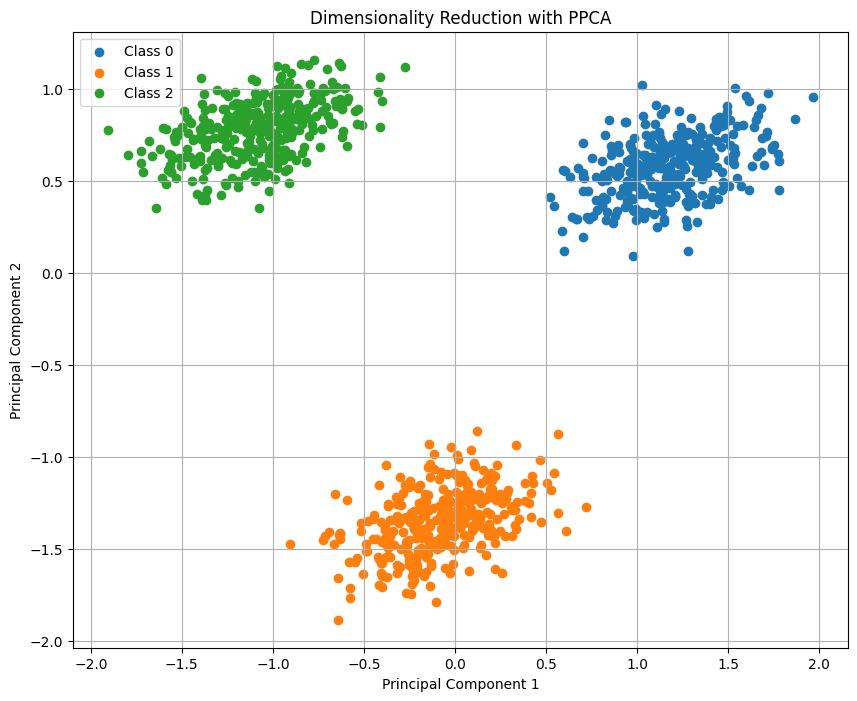

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate synthetic data with true labels
n_samples = 1000
n_features = 5
n_components = 2  # Number of components for dimensionality reduction
n_clusters = 3  # Number of clusters

# Generate the synthetic dataset
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
X = StandardScaler().fit_transform(X)

# Initialize parameters for PPCA
np.random.seed(42)
W = np.random.randn(n_features, n_components)
mu = np.mean(X, axis=0)
sigma2 = 1

# PPCA EM algorithm
max_iter = 100
tolerance = 1e-4

for iteration in range(max_iter):
    # E-step
    M = W.T @ W + sigma2 * np.eye(n_components)
    M_inv = np.linalg.inv(M)
    
    Ez = np.zeros((n_samples, n_components))
    Covz = sigma2 * M_inv
    
    for i in range(n_samples):
        xi = X[i]
        Ez[i] = M_inv @ W.T @ (xi - mu)
    
    # M-step
    mu_new = np.mean(X, axis=0)
    
    S_xz = np.zeros((n_features, n_components))
    S_zz = np.zeros((n_components, n_components))
    
    for i in range(n_samples):
        xi = X[i]
        Ezi = Ez[i]
        S_xz += np.outer(xi - mu_new, Ezi)
        S_zz += Covz + np.outer(Ezi, Ezi)
    
    S_xz /= n_samples
    S_zz /= n_samples
    
    W_new = S_xz @ np.linalg.inv(S_zz)
    
    sigma2_new = 0
    for i in range(n_samples):
        xi = X[i]
        Ezi = Ez[i]
        sigma2_new += np.linalg.norm(xi - mu_new - W_new @ Ezi)**2 + np.trace(W_new @ Covz @ W_new.T)
    
    sigma2_new /= (n_features * n_samples)
    
    # Check for convergence
    if np.linalg.norm(W_new - W) < tolerance and np.abs(sigma2_new - sigma2) < tolerance:
        break
    
    W, mu, sigma2 = W_new, mu_new, sigma2_new

# Project data to lower dimension
X_reduced = Ez

# Plot the reduced data with true labels
plt.figure(figsize=(10, 8))
for label in np.unique(y):
    plt.scatter(X_reduced[y == label, 0], X_reduced[y == label, 1], label=f'Class {label}')
plt.title('Dimensionality Reduction with PPCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### A quick look on the dimensionality reduction with PCA and t-SNE

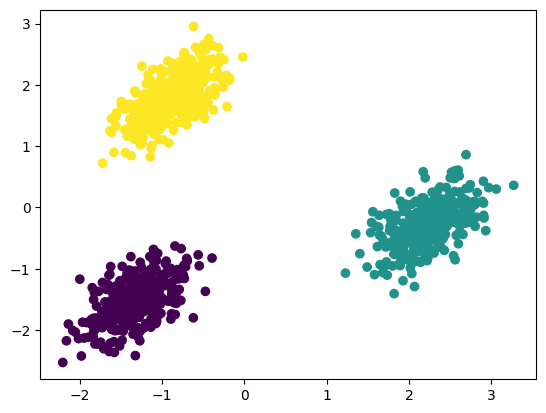

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap='viridis');

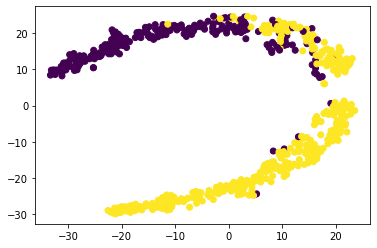

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y, cmap='viridis');